In [1]:
import tqdm
import torch
import open3d as o3d
import more_itertools
from torch import Tensor
from typing import Iterator,NamedTuple
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from os import path, makedirs, listdir

from osg.utils.dataset_class import PosedRGBDItem,R3DDataset

/Users/benedictquartey/opt/miniconda3/envs/osg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_posed_rgbd_dataset(key: str,path: str) -> Dataset[PosedRGBDItem]:
        return R3DDataset(path)

def get_inv_intrinsics(intrinsics: Tensor) -> Tensor:
    # return intrinsics.double().inverse().to(intrinsics)
    fx, fy, ppx, ppy = intrinsics[..., 0, 0], intrinsics[..., 1, 1], intrinsics[..., 0, 2], intrinsics[..., 1, 2]
    inv_intrinsics = torch.zeros_like(intrinsics)
    inv_intrinsics[..., 0, 0] = 1.0 / fx
    inv_intrinsics[..., 1, 1] = 1.0 / fy
    inv_intrinsics[..., 0, 2] = -ppx / fx
    inv_intrinsics[..., 1, 2] = -ppy / fy
    inv_intrinsics[..., 2, 2] = 1.0
    return inv_intrinsics

def get_xyz(depth: Tensor, mask: Tensor, pose: Tensor, intrinsics: Tensor) -> Tensor:
    """Returns the XYZ coordinates for a set of points.

    Args:
        depth: The depth array, with shape (B, 1, H, W)
        mask: The mask array, with shape (B, 1, H, W)
        pose: The pose array, with shape (B, 4, 4)
        intrinsics: The intrinsics array, with shape (B, 3, 3)

    Returns:
        The XYZ coordinates of the projected points, with shape (B, H, W, 3)
    """

    (bsz, _, height, width), device, dtype = depth.shape, depth.device, intrinsics.dtype

    # Gets the pixel grid.
    xs, ys = torch.meshgrid(
        torch.arange(0, width, device=device, dtype=dtype),
        torch.arange(0, height, device=device, dtype=dtype),
        indexing="xy",
    )
    xy = torch.stack([xs, ys], dim=-1).flatten(0, 1).unsqueeze(0).repeat_interleave(bsz, 0)
    xyz = torch.cat((xy, torch.ones_like(xy[..., :1])), dim=-1)

    # Applies intrinsics and extrinsics.
    # xyz = xyz @ intrinsics.inverse().transpose(-1, -2)
    xyz = xyz @ get_inv_intrinsics(intrinsics).transpose(-1, -2)
    xyz = xyz * depth.flatten(1).unsqueeze(-1)
    xyz = (xyz[..., None, :] * pose[..., None, :3, :3]).sum(dim=-1) + pose[..., None, :3, 3]

    # Mask out bad depth points.
    xyz = xyz.unflatten(1, (height, width))
    xyz[mask.squeeze(1)] = 0.0  #lets do this at the data loading level

    return xyz

def get_pointcloud(ds: Dataset[PosedRGBDItem], chunk_size: int = 16, threshold:float = 0.9, downsample=False) -> Iterator[tuple[Tensor, Tensor]]:
    """Iterates XYZ points from the dataset.

    Args:
        ds: The dataset to iterate points from
        desc: TQDM bar description
        chunk_size: Process this many frames from the dataset at a time

    Yields:
        The XYZ coordinates, with shape (B, H, W, 3), and a mask where a value
        of True means that the XYZ coordinates should be ignored at that
        point, with shape (B, H, W)
    """

    #device = torch.device('cuda') if torch.cuda.is_available() else torch.deivce('cpu')
    ds_len = len(ds)  # type: ignore
    xyzs = []
    rgbs = []

    for inds in more_itertools.chunked(tqdm.trange(ds_len, desc='point cloud'), chunk_size):
        rgb, depth, mask, pose, intrinsics = (
            torch.stack(ts, dim=0)
            for ts in zip(
                #*((t.to(device) for t in (i.image, i.depth, i.mask, i.pose, i.intrinsics)) for i in (ds[i] for i in inds))
                *((t for t in (i.image, i.depth, i.mask, i.pose, i.intrinsics)) for i in (ds[i] for i in inds))
            )
        )
        rgb = rgb.permute(0, 2, 3, 1)
        xyz = get_xyz(depth, mask, pose, intrinsics)
        #mask = (~mask & (torch.rand(mask.shape, device=mask.device) > threshold))
        mask = (~mask & (torch.rand(mask.shape) > threshold)) #depth reading confidence masking
        rgb, xyz = rgb[mask.squeeze(1)], xyz[mask.squeeze(1)]
        rgbs.append(rgb.detach().cpu())
        xyzs.append(xyz.detach().cpu())
    
    xyzs = torch.vstack(xyzs)
    rgbs = torch.vstack(rgbs)

    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(xyzs)
    merged_pcd.colors = o3d.utility.Vector3dVector(rgbs)
    if downsample:
        vl_size = 0.02
        print(f"Downsampling pointcloud || voxel_size: {vl_size}... ")
        merged_pcd = merged_pcd.voxel_down_sample(voxel_size=vl_size)
    else:
         print("Skipped downsampling ... ")
    return merged_pcd

#function to generate random numeric alphanumeric string
def random_string(string_length=20):
    import random
    import string
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

In [3]:
# input_file = "sample_data/sample.r3d" 
input_file = "../data/sample_r3d_data/bdai_kitchen.r3d" 
output_file = "r3dpointcloud.pcd"
posed_dataset = get_posed_rgbd_dataset(key="r3d", path=input_file)

Loading R3D file: 100%|██████████| 145/145 [00:02<00:00, 55.50it/s]


In [4]:
#test saving fused pointcloud
#threshold determines number of points to be included in the pointcloud
env_pcd = get_pointcloud(posed_dataset, threshold=0.7, downsample=False)
o3d.io.write_point_cloud(output_file, env_pcd)
print("... pointcloud created ")

point cloud: 100%|██████████| 145/145 [00:00<00:00, 391.06it/s]


Skipped downsampling ... 
... pointcloud created 


### Play around with one sample

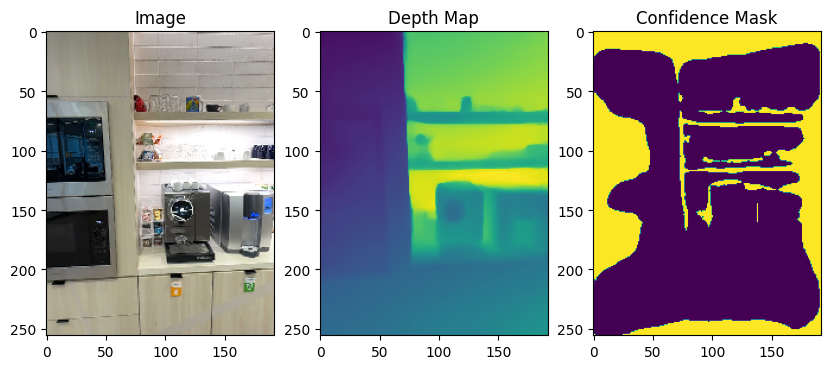

In [6]:
#Sample item
index = 10
sample_posedrgbd_item = posed_dataset.__getitem__(index)
sample_image = sample_posedrgbd_item.image
sample_depth = sample_posedrgbd_item.depth
sample_mask = sample_posedrgbd_item.mask
sample_intrinsics = sample_posedrgbd_item.intrinsics
sample_pose = sample_posedrgbd_item.pose

#plot image and dept map side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0))
plt.title("Image")
plt.subplot(1, 3, 2)
plt.imshow(sample_depth.squeeze(0))
plt.title("Depth Map")
#add confidence mask as subplot
plt.subplot(1, 3, 3)
plt.imshow(sample_mask.squeeze(0))
plt.title("Confidence Mask")
plt.show()

#    #https://developer.apple.com/documentation/arkit/arconfidencelevel,
#ARKIT confidence masks have 3 values
# case low: 0
    # Depth-value accuracy in which the framework is less confident.

# case medium: 1
    # Depth-value accuracy in which the framework is moderately confident.

# case high: 2
    # Depth-value accuracy in which the framework is fairly confident.

#in loading data we do:
# masks_arrs = conf_arrs != 2   # 2 is the value for a highest confidence depth point, 
                                # set to False and set all others to True || we can invert this mask when it is used


In [ ]:
#backprojecting single image

# ds_len = len(ds)  # type: ignore
xyzs = []
rgbs = []
res = [sample_posedrgbd_item]
threshold = 0.9

rgb, depth, mask, pose, intrinsics = sample_image, sample_depth, sample_mask, sample_pose, sample_intrinsics

#expand dims to include batch size  
rgb = rgb.unsqueeze(0)
depth = depth.unsqueeze(0)
mask = mask.unsqueeze(0)
pose = pose.unsqueeze(0)

print(rgb.shape)
rgb = rgb.permute(0, 2, 3, 1)
xyz = get_xyz(depth, mask, pose, intrinsics)



# #mask = (~mask & (torch.rand(mask.shape, device=mask.device) > threshold))
# mask = (~mask & (torch.rand(mask.shape) > 0))
# print("before masking", rgb.shape)
# rgb, xyz = rgb[mask.squeeze(1)], xyz[mask.squeeze(1)]
# print("after masking", rgb.shape)
# # rgb, xyz = rgb, xyz
# rgbs.append(rgb.detach().cpu())
# xyzs.append(xyz.detach().cpu())

# xyzs = torch.vstack(xyzs)
# rgbs = torch.vstack(rgbs)

# merged_pcd = o3d.geometry.PointCloud()
# merged_pcd.points = o3d.utility.Vector3dVector(xyzs)
# merged_pcd.colors = o3d.utility.Vector3dVector(rgbs)
# # merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.03)
# merged_downpcd = merged_pcd

# #view point cloud
# # o3d.visualization.draw_geometries([merged_downpcd])
# o3d.io.write_point_cloud("single_rgbd.ply", merged_downpcd)
